<a href="https://colab.research.google.com/github/Dami442/mlproject/blob/main/Fin_inc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from google.colab import files
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Data/"
train = pd.read_csv(path+'Train.csv')
test = pd.read_csv(path+'Test.csv')
ss = pd.read_csv(path+'SampleSubmission.csv')
variables = pd.read_csv(path+'VariableDefinitions.csv')

In [ ]:
print("train data shape: ", train.shape)
print("test data shape: ", test.shape)

train data shape:  (23524, 13)
test data shape:  (10086, 12)


In [ ]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [ ]:
print("Missing values: ", train.isnull().sum())

Missing values:  country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64


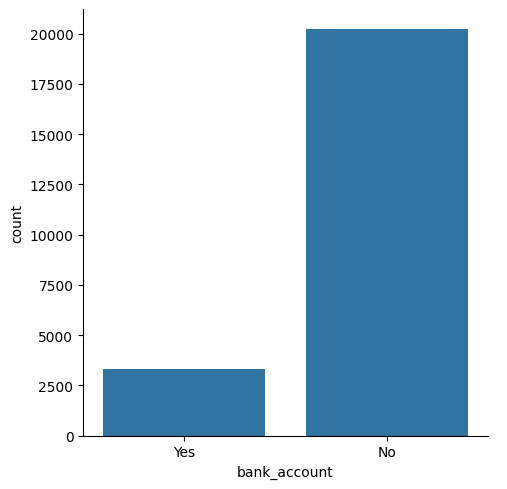

In [ ]:
# Explore target distro

sns.catplot(x="bank_account", kind="count", data=train)

In [ ]:
ss.head()

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,0
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0


In [ ]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB
None


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

#Convert target variable to num data
le = LabelEncoder()
train["bank_account"] = le.fit_transform(train["bank_account"])

# separate data into variables and target

X_train = train.drop(["bank_account"], axis=1)
y_train = train["bank_account"]

print(y_train)



0        1
1        0
2        1
3        0
4        0
        ..
23519    0
23520    0
23521    0
23522    0
23523    0
Name: bank_account, Length: 23524, dtype: int64


In [ ]:
train.head()



,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,1,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,0,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,1,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,0,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,0,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [ ]:
def preprocessing_data(data):
  float_array = data[["household_size", "age_of_respondent", "year"]]

  categ = ["relationship_with_head",
           "marital_status",
           "education_level",
           "job_type",
           "country"]

  # One Hot Encoding
  data = pd.get_dummies(data, prefix_sep="_", columns=categ)

  # label encoder conversion

  data["location_type"] = le.fit_transform(data["location_type"])
  data["cellphone_access"] = le.fit_transform(data["cellphone_access"])
  data["gender_of_respondent"] = le.fit_transform(data["gender_of_respondent"])

  # drop uniqueid column

  data = data.drop(["uniqueid"], axis= 1)

  scaler = MinMaxScaler(feature_range=(0, 1))
  data = scaler.fit_transform(data)


  return data



In [ ]:
# Preprocess the data

processed_train = preprocessing_data(X_train)
processed_test = preprocessing_data(test)

In [ ]:
print(processed_train[:1])

[[1.        0.        1.        0.1       0.0952381 0.        0.
  0.        0.        0.        0.        1.        0.        0.
  1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        1.        1.        0.
  0.        0.       ]]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_Train, y_val = train_test_split(processed_train, y_train, stratify=y_train,
                                                  test_size=0.1, random_state=20)



In [ ]:
from xgboost import XGBClassifier

xg_model = XGBClassifier()

xg_model.fit(X_train,y_Train)
xg_model.predict(X_val)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

xg_y_model = xg_model.predict(X_val)

# get error rate
print("Error rate of classifier: ", 1 - accuracy_score(y_val, xg_y_model))

Error rate of classifier:  0.11134721631959199


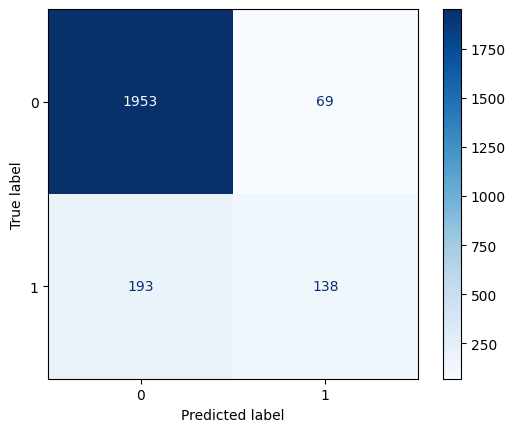

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_val, xg_model.predict(X_val))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
# Import GridSearch
from sklearn.model_selection import GridSearchCV
param_grid = {'min_child_weight':[1,5,10],
              'gamma' : [0.5,1],
              'subsample' : [0.6,0.8,1.0],
              'max_depth' : [3, 5]
    }

my_xgb_model = GridSearchCV(xg_model, param_grid, n_jobs=-1,verbose=2,cv=5)
my_xgb_model.fit(X_train, y_Train)
print(my_xgb_model.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'gamma': 1, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 1.0}


In [ ]:
xgb_model = XGBClassifier(min_child_weight = 5, gamma=1, max_depth=5, subsample=1.0)

xgb_model.fit(X_train, y_Train)

y_pred = xgb_model.predict(X_val)

# Error rate
print("Error rate of the XGB classifier: ", 1 - accuracy_score(y_val, y_pred))

Error rate of the XGB classifier:  0.11687207819804502


In [ ]:
# Get the predicted result for the test Data
test.bank_account = xgb_model.predict(processed_test)

In [ ]:
# Create submission DataFrame
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": test.bank_account})

In [ ]:
#show the five sample
submission.sample(5)

,uniqueid,bank_account
6093,uniqueid_12228 x Rwanda,1
8061,uniqueid_8336 x Tanzania,0
107,uniqueid_6176 x Kenya,0
5934,uniqueid_12069 x Rwanda,0
8604,uniqueid_8879 x Tanzania,0


In [ ]:
# Create submission csv file csv file
submission.to_csv('second_submission.csv', index = False)
files.download('second_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>